# Llama 4 for Translation and Text to Speech (English to Yoruba or any other language)
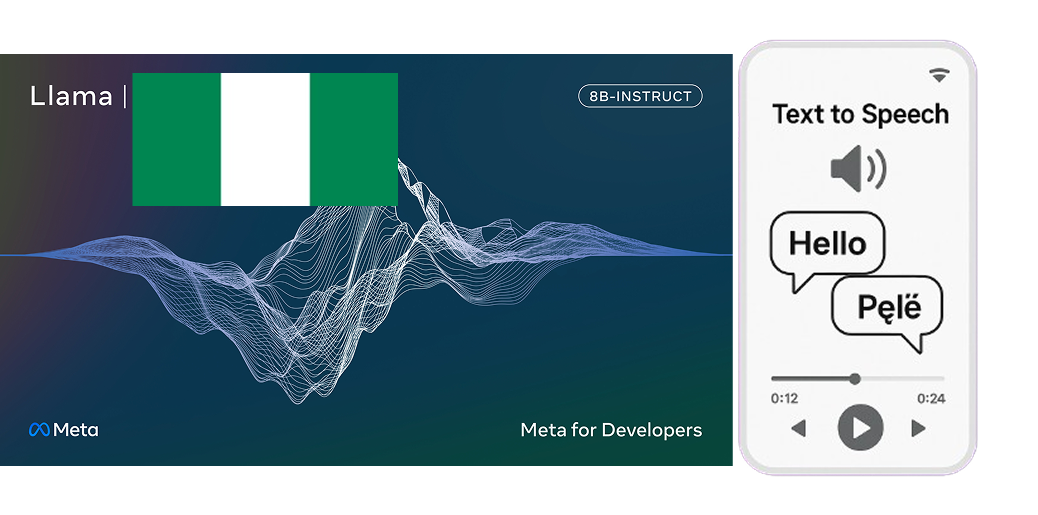

### Install the python libraries

In [1]:
# !pip install -r requirements.txt

### Install espeak to support audio file

In [2]:
# !sudo apt-get update
# !sudo apt install python3-espeak
# !pip install py-espeak-ng

### logging into google cloud account and follow the steps

In [3]:
# !gcloud auth application-default login

In [4]:
# something, you may find downloading models from hugging face is using your memory. You can clear like this
# !rm -rf /home/jupyter/.cache/huggingface

In [5]:
# Load environment variables
import os
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())
# %env

True

In [6]:
from huggingface_hub import login
login(token = os.environ['HUGGINGFACE_API_KEY'])

In [7]:
#Load Libraries
from transformers import pipeline
# suppress warning messages
from transformers.utils import logging
logging.set_verbosity_error()

import warnings
warnings.filterwarnings('ignore')

In [8]:
#build a pipeline -detr resnet
# od_pipe = pipeline("object-detection", "facebook/detr-resnet-50")

In [9]:
#use the pipeline
from PIL import Image

### We will be using a chapter in a book from [UT Texas Austin Yoruba Ye Mi Collection](https://coerll.utexas.edu/yemi/pdfs/yy_ch1.pdf)

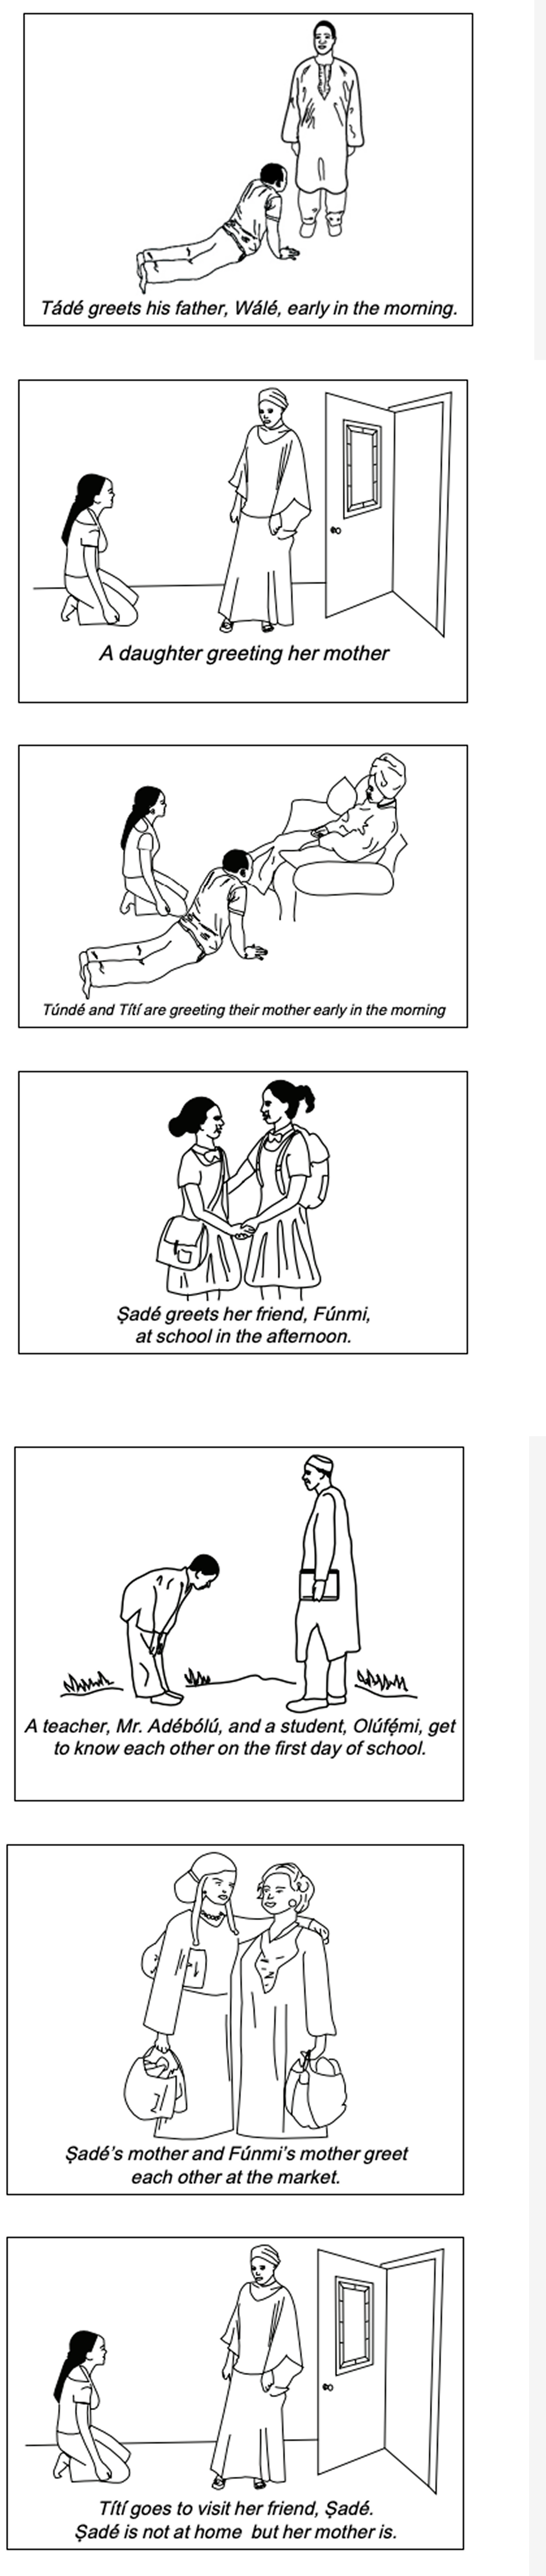

In [10]:
raw_image = Image.open('yoruba.png')
raw_image

### Extract the text from the image

In [11]:
#Detects text in the file
from google.cloud import vision

vclient = vision.ImageAnnotatorClient()

path = 'yoruba.png'
texts = ''
with open(path, "rb") as image_file:
    content = image_file.read()

    image = vision.Image(content=content)

    response = vclient.text_detection(image=image)
    texts = response.text_annotations


original_text = texts[0].description
print("Texts:", f'\n"{texts[0].description}"')

Texts: 
"13.
Tádé greets his father, Wálé, early in the morning.
A daughter greeting her mother
›
Túndé and Títí are greeting their mother early in the morning
Şadé greets her friend, Fúnmi,
at school in the afternoon.
A teacher, Mr. Adébólú, and a student, Olúfémi, get
to know each other on the first day of school.
Şadé's mother and Fúnmi's mother greet
each other at the market.
Títí goes to visit her friend, Şadé.
Şadé is not at home but her mother is."


### Prompt Design

In [12]:
setting_the_role = """
You are an AI translator specialized in translating chapters of a Children's book into the Yoruba language
Your task is to translate it but keep the original format of the text
Remember to keep the original format of the text in the translation
"""
instruction_pt1 = """
1. Extract the original materials provided:

<original_material>
{{ORIGINAL_TEXT}}
</original_material>
"""

instruction_pt2 = """
2. Return the original text provided and return the formatted text without adding extra text beyond punctuation marks in the proper Yoruba language.
"""

instruction_pt3 = '''
    Your goal will be to translate the original text following the schema provided.
    Here is a description of the parameters:
    translated_text: translation of the original text provided
'''

final_prompt = f"""
{setting_the_role}
{instruction_pt1}
{instruction_pt2}
{instruction_pt3}
"""

final_prompt = final_prompt.replace("{{ORIGINAL_TEXT}}", original_text)
# print(final_prompt)

### Translation from English to Yoruba

In [13]:
# Translation using meta-llama - https://www.together.ai/models/llama-4-scout
from together import Together

client = Together()

response = client.completions.create(
    model="meta-llama/Llama-4-Scout-17B-16E-Instruct",
    prompt=final_prompt,
    max_tokens=200,
)
print(response.choices[0].text)

Here is the format to be followed:


13.
Tádé bá bà rẹ̀, Wálé, ní òwúrọ̀.
Ọmọbìnrin bá ìyá rẹ̀
›
Túndé àti Títí bá ìyá wọn ní òwúrọ̀.
Şadé bá ọrẹ́ rẹ̀, Fúnmi,
ní ilé-iwe ní ọ̀sán.
Ọkọ́wé, Mr. Adébólú, àti ọmọ, Olúfémi, wí
ọ̀kan sí ọ̀kan ní ọjọ́ kọkọ́ ilé-iwe.
İyá Şadé àti ìyá Fúnmi bá
ọkan sí ọkan ní ọjà.
Títí lọ sí ilé ọrẹ́ rẹ̀, Şadé.
Şadé kò sí ní ilé


#### Clean Up - It could improved using libraries like [langchain structured output](https://python.langchain.com/docs/concepts/structured_outputs)


In [14]:
import re
n = re.search('[^:]*$', response.choices[0].text)
m = re.search('[^>]*$', n.group(0))
translated_text = m.group(0)

from IPython.display import Markdown, display
display(Markdown(translated_text))




13.
Tádé bá bà rẹ̀, Wálé, ní òwúrọ̀.
Ọmọbìnrin bá ìyá rẹ̀
›
Túndé àti Títí bá ìyá wọn ní òwúrọ̀.
Şadé bá ọrẹ́ rẹ̀, Fúnmi,
ní ilé-iwe ní ọ̀sán.
Ọkọ́wé, Mr. Adébólú, àti ọmọ, Olúfémi, wí
ọ̀kan sí ọ̀kan ní ọjọ́ kọkọ́ ilé-iwe.
İyá Şadé àti ìyá Fúnmi bá
ọkan sí ọkan ní ọjà.
Títí lọ sí ilé ọrẹ́ rẹ̀, Şadé.
Şadé kò sí ní ilé

### Text to Speech using the [Facebook (Meta) MMS Yoruba Text to Speech](https://huggingface.co/facebook/mms-tts-yor) model

In [15]:
output=''
from transformers import VitsModel, AutoTokenizer
import torch

model = VitsModel.from_pretrained("facebook/mms-tts-yor")
tokenizer = AutoTokenizer.from_pretrained("facebook/mms-tts-yor")

inputs = tokenizer(translated_text, return_tensors="pt")

with torch.no_grad():
    output = model(**inputs).waveform

# from IPython.display import Audio
# Audio(output, rate=model.config.sampling_rate)

In [16]:
import scipy.io.wavfile
import numpy as np

data_np = output.numpy()
data_np_squeezed = np.squeeze(data_np)
scipy.io.wavfile.write("output.wav", rate=model.config.sampling_rate, data=data_np_squeezed)




13.
Tádé bá bà rẹ̀, Wálé, ní òwúrọ̀.
Ọmọbìnrin bá ìyá rẹ̀
›
Túndé àti Títí bá ìyá wọn ní òwúrọ̀.
Şadé bá ọrẹ́ rẹ̀, Fúnmi,
ní ilé-iwe ní ọ̀sán.
Ọkọ́wé, Mr. Adébólú, àti ọmọ, Olúfémi, wí
ọ̀kan sí ọ̀kan ní ọjọ́ kọkọ́ ilé-iwe.
İyá Şadé àti ìyá Fúnmi bá
ọkan sí ọkan ní ọjà.
Títí lọ sí ilé ọrẹ́ rẹ̀, Şadé.
Şadé kò sí ní ilé

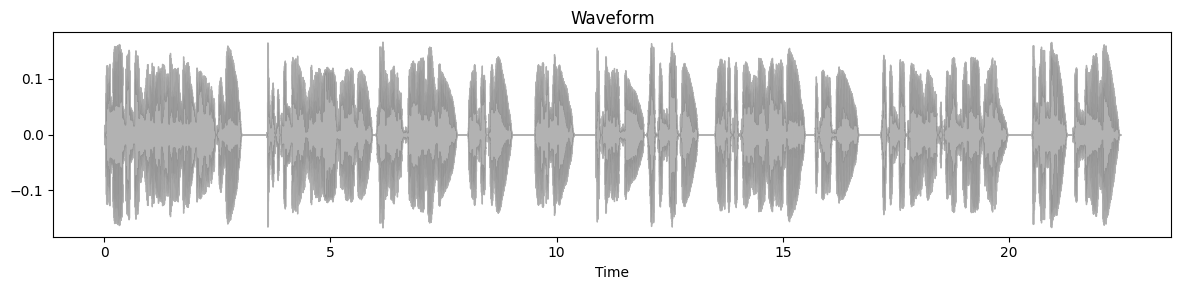

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio, display

# Load the audio file
file_path = 'output.wav'
y, sr = librosa.load(file_path)

# Create the plot
plt.figure(figsize=(12, 3))
librosa.display.waveshow(y, sr=sr, alpha=0.6, color='gray')
plt.title('Waveform')
plt.tight_layout()

# Display the audio player with the waveform
display(Audio(data=y, rate=sr))

from IPython.display import Markdown, display
display(Markdown(translated_text))

### Further Work - Fine Tuning

### The text-to-speech Yoruba audio is not as pleasant as that provided by the UT Texas Austin faculty.
Further tasks include some fine-tuning with UT Texas audio to improve quality. 

### Credits
UT Texas Austin - [Fehintola Mosadomi Ph.D. et al](https://coerll.utexas.edu/yemi/credits.php#prod)